In [ ]:
# Second level test, Nii object, one T, paired T on surface

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib
from brainstat.stats.terms import FixedEffect, MixedEffect
from brainstat.stats.SLM import SLM
from typing import List, Dict, Union, Optional, Sequence
from numpy.typing import ArrayLike
import warnings
from nilearn import surface
warnings.filterwarnings('ignore')

# ------------------------------
# 1. 数据导入模块
# ------------------------------
class DataImporter:
    """
    数据导入模块，用于加载fMRI数据并生成DataFrame.
    """
    def __init__(self, data_dir: str, surface_type: str = 'func'):
        """
        初始化数据导入器。

        Parameters:
        -----------
        data_dir : str
            数据根目录的路径。
        surface_type: str, optional
            表面数据类型 ('func' or 'volumetric'), by default 'func'
        """
        self.data_dir = Path(data_dir)
        self.surface_type = surface_type
        self.subjects: List[str] = []
        self.data: Dict[str, List[np.ndarray]] = {
            'strongly_accept': [],
            'strongly_reject': [],
            'weakly_accept': [],
            'weakly_reject': []
        }
        self.data_df: Optional[pd.DataFrame] = None
        self.original_shape = None
        self.file_paths: Dict[str, Dict[str, List[Path]]] = {
            'strongly_accept': {},
            'strongly_reject': {},
            'weakly_accept': {},
            'weakly_reject': {}
        }
        self.hemispheres = ['L', 'R']
        # 存储每个半球的顶点数
        self.n_vertices_left = None
        self.n_vertices_right = None

    def load_data(self) -> bool:
        """
        加载fMRI数据，并生成DataFrame.
        左右半球的数据将拼接而不是平均。
        """
        print("正在加载数据...")

        # 获取所有被试文件夹
        subject_dirs = [d for d in self.data_dir.iterdir()
                       if d.is_dir() and d.name.startswith('sub-')]

        for sub_dir in sorted(subject_dirs[0:40]):  # 这里仅使用部分被试
            sub_id = sub_dir.name
            stats_dir = sub_dir / 'stats_results'

            if not stats_dir.exists():
                print(f"警告: {sub_id} 缺少stats_results文件夹")
                continue

            # 构建文件路径字典
            files = {
                'strongly_accept': [stats_dir / f"run-{run:02d}" / f"{sub_id}_task-MGT_run-{run:02d}_strongly_accept_zmap.{hemi}.{self.surface_type}.gii" 
                                   for run in range(1, 5) for hemi in self.hemispheres],
                'strongly_reject': [stats_dir / f"run-{run:02d}" / f"{sub_id}_task-MGT_run-{run:02d}_strongly_reject_zmap.{hemi}.{self.surface_type}.gii" 
                                   for run in range(1, 5) for hemi in self.hemispheres],
                'weakly_accept': [stats_dir / f"run-{run:02d}" / f"{sub_id}_task-MGT_run-{run:02d}_weakly_accept_zmap.{hemi}.{self.surface_type}.gii" 
                                 for run in range(1, 5) for hemi in self.hemispheres],
                'weakly_reject': [stats_dir / f"run-{run:02d}" / f"{sub_id}_task-MGT_run-{run:02d}_weakly_reject_zmap.{hemi}.{self.surface_type}.gii" 
                                 for run in range(1, 5) for hemi in self.hemispheres]
            }

            # 加载每个被试的数据
            try:
                subject_data = {}
                valid_subject = True
                
                for condition, file_paths in files.items():
                    condition_data = []
                    
                    # 按run和半球组织数据
                    for run in range(1, 5):
                        run_data = []
                        
                        for hemi in self.hemispheres:
                            # 计算文件索引
                            file_idx = (run-1)*2 + (0 if hemi == 'L' else 1)
                            file_path = file_paths[file_idx]
                            
                            if file_path.exists():
                                try:
                                    img = nib.load(file_path)
                                    data = img.darrays[0].data
                                    
                                    # 记录每个半球的顶点数
                                    if hemi == 'L' and self.n_vertices_left is None:
                                        self.n_vertices_left = len(data)
                                    elif hemi == 'R' and self.n_vertices_right is None:
                                        self.n_vertices_right = len(data)
                                        
                                    run_data.append(data)
                                except Exception as e:
                                    print(f"警告: 加载文件 {file_path.name} 出错: {e}")
                                    valid_subject = False
                            else:
                                print(f"警告: {sub_id} 缺少文件: {file_path.name}")
                                valid_subject = False
                        
                        # 如果成功加载了左右半球数据，则拼接它们
                        if len(run_data) == 2:
                            concatenated_data = np.concatenate(run_data)
                            condition_data.append(concatenated_data)
                    
                    # 对所有run的数据进行平均
                    if condition_data:
                        subject_data[condition] = np.mean(condition_data, axis=0)
                    else:
                        valid_subject = False
                
                # 如果所有条件的数据都成功加载，则添加到总数据中
                if valid_subject and all(cond in subject_data for cond in files.keys()):
                    for condition in files.keys():
                        self.data[condition].append(subject_data[condition])
                    self.subjects.append(sub_id)
                    
                    # 存储文件路径
                    for condition, file_paths in files.items():
                        self.file_paths[condition][sub_id] = file_paths
                else:
                    print(f"警告: {sub_id} 缺少某些条件的数据，跳过该被试")
                    
            except Exception as e:
                print(f"错误: 无法加载 {sub_id} 的数据: {e}")
                continue

        print(f"成功加载 {len(self.subjects)} 个被试的数据")

        # 将数据转换为numpy数组 (subjects, vertices)
        for condition in self.data:
            if self.data[condition]:
                self.data[condition] = np.stack(self.data[condition])
                if self.original_shape is None:
                    self.original_shape = self.data[condition].shape[1:]

        # 创建DataFrame
        self.data_df = self._create_dataframe()
        return len(self.subjects) > 0

    def _create_dataframe(self) -> pd.DataFrame:
        """
        创建包含所有数据的DataFrame.
        """
        if not self.subjects or not self.data:
            return None
            
        data = []
        for sub_idx, sub_id in enumerate(self.subjects):
            for condition in self.data.keys():
                if condition in self.file_paths and sub_id in self.file_paths[condition]:
                    for file_path in self.file_paths[condition][sub_id]:
                        data.append({
                            'subject': sub_id,
                            'condition': condition,
                            'file_path': str(file_path)
                        })
        return pd.DataFrame(data)

    def get_data_for_analysis(self, conditions: List[str]) -> np.ndarray:
        """
        根据条件获取分析所需的数据。
        
        Parameters:
        -----------
        conditions : List[str]
            需要分析的条件列表
            
        Returns:
        --------
        np.ndarray
            形状为 (被试数量, 条件数量, 顶点数量) 的数据数组
        """
        if not self.data:
            raise ValueError("数据尚未加载.")
            
        # 初始化一个列表来存储数据
        all_data = []
        
        for sub_idx, sub_id in enumerate(self.subjects):
            subject_data = []
            
            for condition in conditions:
                if condition in self.data and sub_idx < len(self.data[condition]):
                    subject_data.append(self.data[condition][sub_idx])
                else:
                    print(f"警告: {sub_id} 的 {condition} 数据不存在.")
                    # 创建一个与原始形状匹配的NaN数组
                    nan_data = np.full(self.original_shape, np.nan)
                    subject_data.append(nan_data)
            
            # 检查所有条件的数据是否都有效
            if not any(np.isnan(d).all() for d in subject_data):
                all_data.append(np.stack(subject_data))
            else:
                print(f"警告: {sub_id} 的数据缺失，跳过该被试")
        
        if not all_data:
            return None
            
        # 返回numpy数组，维度为 (被试数量, 条件数量, 顶点数量)
        return np.stack(all_data)
    
    def get_hemisphere_mask(self) -> np.ndarray:
        """
        获取一个掩码数组，标识哪些顶点属于左半球，哪些属于右半球。
        
        Returns:
        --------
        np.ndarray
            布尔数组，True表示左半球顶点，False表示右半球顶点
        """
        if self.n_vertices_left is None or self.n_vertices_right is None:
            raise ValueError("尚未加载数据，无法确定半球顶点数")
            
        total_vertices = self.n_vertices_left + self.n_vertices_right
        mask = np.zeros(total_vertices, dtype=bool)
        mask[:self.n_vertices_left] = True  # 左半球
        
        return mask

In [ ]:
# 设置路径
data_dir = r"C:\tmpusing\derivatives\first_level_model_corrected_gii"
output_dir = r"C:\tmpusing\derivatives\second_level_results_corrected_gii"
# 1. 数据导入, 这里根据自己的数据和实际路径修改数据的导入函数
data_importer = DataImporter(data_dir)
if not data_importer.load_data():
    print("数据加载失败，程序终止。")

正在加载数据...
警告: sub-003 缺少文件: sub-003_task-MGT_run-01_strongly_reject_zmap.L.func.gii
警告: sub-003 缺少文件: sub-003_task-MGT_run-01_strongly_reject_zmap.R.func.gii
警告: sub-003 缺少文件: sub-003_task-MGT_run-02_strongly_reject_zmap.L.func.gii
警告: sub-003 缺少文件: sub-003_task-MGT_run-02_strongly_reject_zmap.R.func.gii
警告: sub-003 缺少文件: sub-003_task-MGT_run-03_strongly_reject_zmap.L.func.gii
警告: sub-003 缺少文件: sub-003_task-MGT_run-03_strongly_reject_zmap.R.func.gii
警告: sub-003 缺少文件: sub-003_task-MGT_run-04_strongly_reject_zmap.L.func.gii
警告: sub-003 缺少文件: sub-003_task-MGT_run-04_strongly_reject_zmap.R.func.gii
警告: sub-003 缺少文件: sub-003_task-MGT_run-03_weakly_accept_zmap.L.func.gii
警告: sub-003 缺少文件: sub-003_task-MGT_run-03_weakly_accept_zmap.R.func.gii
警告: sub-003 缺少文件: sub-003_task-MGT_run-04_weakly_accept_zmap.L.func.gii
警告: sub-003 缺少文件: sub-003_task-MGT_run-04_weakly_accept_zmap.R.func.gii
警告: sub-003 缺少某些条件的数据，跳过该被试
警告: sub-011 缺少文件: sub-011_task-MGT_run-02_weakly_reject_zmap.L.func.gii
警告: sub-01

In [ ]:
data_importer.data['strongly_accept'][9][20482]

-0.25

In [ ]:
# ------------------------------
# 2. 单样本T检验模块
# ------------------------------
class OneSampleTTest:
    """
    单样本T检验模块.
    """
    def __init__(self, data_importer: DataImporter, surface_name: str = "fsaverage5"):
        """
        初始化单样本T检验器。

        Parameters:
        -----------
        data_importer : DataImporter
            数据导入器对象。
        surface_name : str, optional
            表面模板名称，默认为 "fsaverage5"
        """
        self.data_importer = data_importer
        self.surface_name = surface_name

    def run_test(self, condition: str) -> SLM:
        """
        运行单样本T检验。

        Parameters:
        -----------
        condition : str
            要分析的条件 ('accept' 或 'reject').

        Returns:
        --------
        SLM
            BrainStat SLM对象，包含统计结果。
        """
        print(f"\n执行单样本T检验: {condition}")

        if condition == 'accept':
            conditions = ['strongly_accept', 'weakly_accept']
        elif condition == 'reject':
            conditions = ['strongly_reject', 'weakly_reject']
        else:
            raise ValueError("condition 必须是 'accept' 或 'reject'")

        # 获取分析所需的数据, 维度为 (被试数量, 2, 顶点数量)
        data = self.data_importer.get_data_for_analysis(conditions)

        # 如果数据获取失败，直接返回None
        if data is None:
            print(f"没有 {condition} 的有效数据，跳过单样本T检验。")
            return None

        # 对 accept 和 reject 计算平均值, (被试数量, 顶点数量)
        data = np.mean(data, axis=1)

        # 创建设计矩阵（截距项）
        n_subjects = data.shape[0]
        intercept = FixedEffect(np.ones(n_subjects))

        # 创建对比向量（测试均值是否显著不同于0）
        contrast = np.ones(n_subjects).astype(int)

        # 获取半球掩码
        hemisphere_mask = self.data_importer.get_hemisphere_mask()
        n_vertices_left = np.sum(hemisphere_mask)
        n_vertices_right = np.sum(~hemisphere_mask)

        # 创建SLM对象
        slm = SLM(
            model=intercept,
            contrast=contrast,
            surf=self.surface_name,  # 使用表面名称而不是mask
            mask=None,    # 不使用半球掩码
            correction=['fdr', 'rft'],
            cluster_threshold=0.001,
            two_tailed=True
        )

        # 拟合模型
        try:
            slm.fit(data)
            print(f"{condition} 单样本T检验完成")
            return slm
        except Exception as e:
            print(f"拟合模型时出错: {e}")
            return None


# ------------------------------
# 3. 结果保存模块
# ------------------------------
class ResultSaver:
    """
    结果保存模块.
    """
    def __init__(self, output_dir: str, n_vertices_left: int, n_vertices_right: int):
        """
        初始化结果保存器。

        Parameters:
        -----------
        output_dir : str
            输出目录的路径。
        n_vertices_left : int
            左半球的顶点数量。
        n_vertices_right : int
            右半球的顶点数量。
        """
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True, parents=True)
        self.n_vertices_left = n_vertices_left
        self.n_vertices_right = n_vertices_right

    def save_results(self, slm_results: Union[SLM, Dict[str, SLM]], analysis_name: str):
        """
        保存统计结果.

        Parameters:
        -----------
        slm_results : SLM or Dict[str, SLM]
            统计结果 (SLM对象或包含SLM对象的字典)。
        analysis_name : str
            分析的名称，用于命名输出文件。
        """
        if isinstance(slm_results, dict):
            # 多个对比的结果
            for contrast_name, slm in slm_results.items():
                self._save_single_result(slm, f"{analysis_name}_{contrast_name}")
        else:
            # 单个结果
            self._save_single_result(slm_results, analysis_name)

    def _save_single_result(self, slm: SLM, name: str):
        """
        保存单个统计结果.
        """
        try:
            # 保存T统计图
            if hasattr(slm, 't') and slm.t is not None:
                t_map = slm.t[0]
                
                # 分离左右半球
                t_map_L = t_map[:self.n_vertices_left]
                t_map_R = t_map[self.n_vertices_left:self.n_vertices_left + self.n_vertices_right]
                
                # 创建GIFTI数据数组
                t_map_L_darray = nib.gifti.GiftiDataArray(data=t_map_L.astype(np.float32))
                t_map_R_darray = nib.gifti.GiftiDataArray(data=t_map_R.astype(np.float32))
                
                # 创建GIFTI图像
                t_img_L = nib.gifti.GiftiImage(darrays=[t_map_L_darray])
                t_img_R = nib.gifti.GiftiImage(darrays=[t_map_R_darray])
                
                # 保存GIFTI图像
                nib.save(t_img_L, self.output_dir / f"{name}_tstat.L.func.gii")
                nib.save(t_img_R, self.output_dir / f"{name}_tstat.R.func.gii")

            # 保存P值图
            if hasattr(slm, 'P') and slm.P is not None:
                p_map = slm.P['pval']['P']
                
                # 分离左右半球
                p_map_L = p_map[:self.n_vertices_left]
                p_map_R = p_map[self.n_vertices_left:self.n_vertices_left + self.n_vertices_right]
                
                # 创建GIFTI数据数组
                p_map_L_darray = nib.gifti.GiftiDataArray(data=p_map_L.astype(np.float32))
                p_map_R_darray = nib.gifti.GiftiDataArray(data=p_map_R.astype(np.float32))
                
                # 创建GIFTI图像
                p_img_L = nib.gifti.GiftiImage(darrays=[p_map_L_darray])
                p_img_R = nib.gifti.GiftiImage(darrays=[p_map_R_darray])
                
                # 保存GIFTI图像
                nib.save(p_img_L, self.output_dir / f"{name}_pstat.L.func.gii")
                nib.save(p_img_R, self.output_dir / f"{name}_pstat.R.func.gii")

            # 保存校正后的P值图
            if hasattr(slm, 'Q') and slm.Q is not None:
                q_map = slm.Q
                
                # 分离左右半球
                q_map_L = q_map[:self.n_vertices_left]
                q_map_R = q_map[self.n_vertices_left:self.n_vertices_left + self.n_vertices_right]
                
                # 创建GIFTI数据数组
                q_map_L_darray = nib.gifti.GiftiDataArray(data=q_map_L.astype(np.float32))
                q_map_R_darray = nib.gifti.GiftiDataArray(data=q_map_R.astype(np.float32))
                
                # 创建GIFTI图像
                q_img_L = nib.gifti.GiftiImage(darrays=[q_map_L_darray])
                q_img_R = nib.gifti.GiftiImage(darrays=[q_map_R_darray])
                
                # 保存GIFTI图像
                nib.save(q_img_L, self.output_dir / f"{name}_qstat_fdr.L.func.gii")
                nib.save(q_img_R, self.output_dir / f"{name}_qstat_fdr.R.func.gii")

            print(f"已保存结果: {name}")

        except Exception as e:
            print(f"保存结果时出错 {name}: {e}")
#单样本T检验
result_saver = ResultSaver(output_dir, 10242,10242)
one_sample_tester = OneSampleTTest(data_importer)
slm_accept = one_sample_tester.run_test('accept')
slm_reject = one_sample_tester.run_test('reject')
result_saver.save_results(slm_accept, 'one_sample_accept')
result_saver.save_results(slm_reject, 'one_sample_accept')


执行单样本T检验: accept
accept 单样本T检验完成

执行单样本T检验: reject
reject 单样本T检验完成
已保存结果: one_sample_accept
已保存结果: one_sample_accept


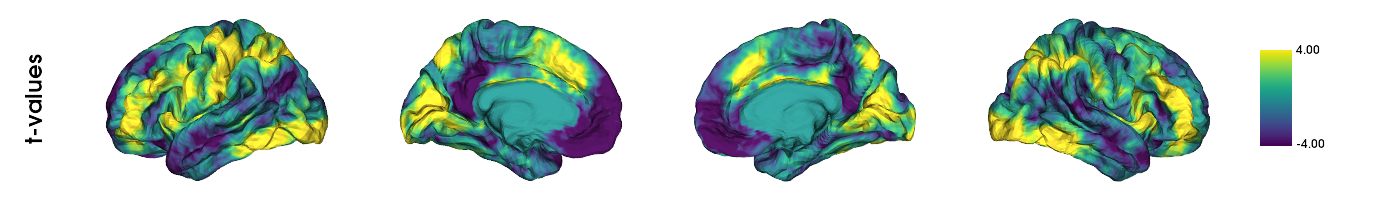

In [ ]:
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainspace.plotting import plot_hemispheres
#绘制原始T值图
pial_left, pial_right = fetch_template_surface("fsaverage5", join=False)
plot_hemispheres(pial_left, pial_right, slm_accept.t[0], color_bar=True, color_range=(-4, 4),
        label_text=["t-values"], cmap="viridis", embed_nb=True, size=(1400, 200), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False)

2025-08-31 22:13:49,892 - brainstat - INFO - Downloading C:\Users\Administrator\brainstat_data\surface_data\fsaverage5_mask.csv from https://box.bic.mni.mcgill.ca/s/jsSDyiDcm9KEQpf/download.


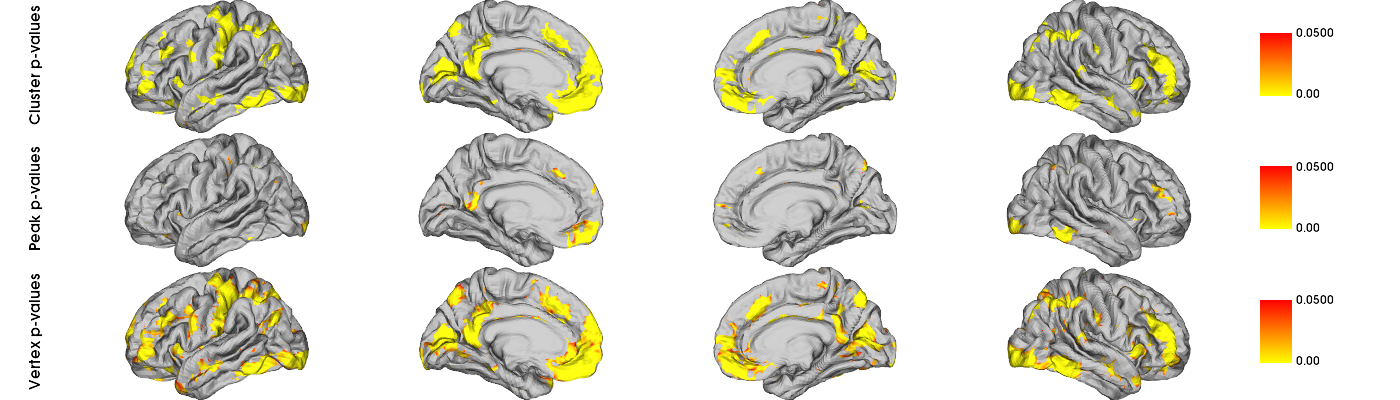

In [ ]:
# 绘制校正后的图
mask = fetch_mask("fsaverage5")
# RFT cluster 水平校正
cp = [np.copy(slm_accept.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]
pp = [np.copy(slm_accept.P["pval"]["P"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in pp]
# vertex 水平的fdr 校正
qp = [np.copy(slm_accept.Q)]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in qp]
vals = np.vstack([cp[0].T, pp[0].T, qp[0].T])
plot_hemispheres(pial_left, pial_right, vals, color_bar=True, color_range=(0, 0.05),
        label_text=["Cluster p-values", "Peak p-values", "Vertex p-values"], cmap="autumn_r", 
        embed_nb=True, size=(1400, 400), zoom=1.8, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12}, interactive=False)


执行配对样本t检验: strongly_accept vs strongly_reject
配对样本t检验完成


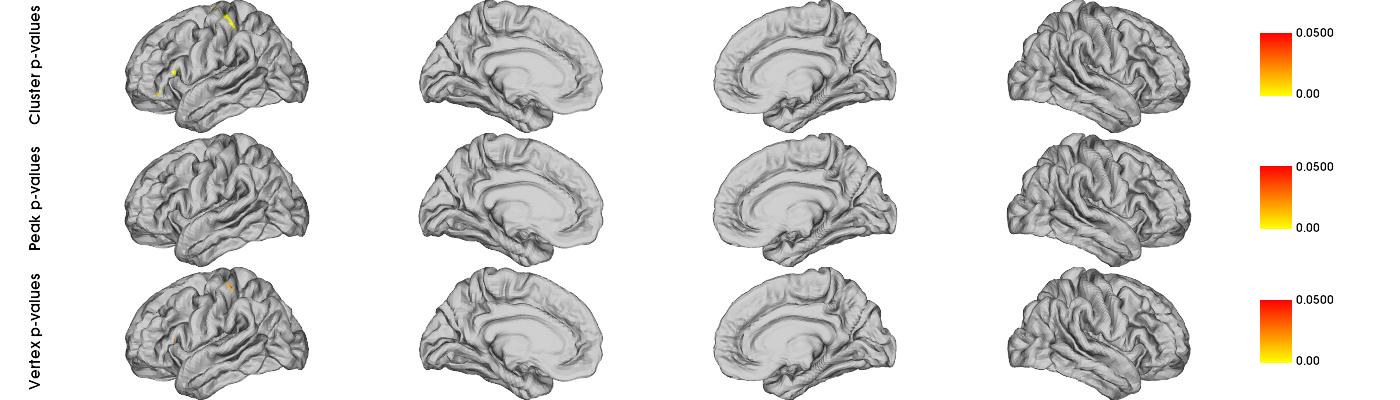

In [ ]:
# ------------------------------
# 3. 配对样本T检验模块
# ------------------------------
class PairedTTest:
    """
    配对样本T检验模块.
    """
    def __init__(self, data_importer: DataImporter, surface_name: str = "fsaverage5"):
        """
        初始化配对样本T检验器。

        Parameters:
        -----------
        data_importer : DataImporter
            数据导入器对象。
        surface_name : str, optional
            表面模板名称，默认为 "fsaverage5"
        """
        self.data_importer = data_importer
        self.surface_name = surface_name

    def run_test(self) -> SLM:
        """
        运行配对样本T检验 (strongly_accept vs strongly_reject).

        Returns:
        --------
        SLM
            BrainStat SLM对象，包含统计结果。
        """
        print("\n执行配对样本t检验: strongly_accept vs strongly_reject")

        conditions = ['strongly_accept', 'strongly_reject']
        data = self.data_importer.get_data_for_analysis(conditions)

        # 如果数据获取失败，直接返回None
        if data is None or data.shape[1] != 2:  # 检查是否成功获取数据，以及是否有两个条件
            print(f"没有 strongly_accept 和 strongly_reject 的有效数据，或数据维度错误，跳过配对T检验。")
            return None

        # 计算差值. data的维度是 (被试数量, 2, 顶点数量), 这里计算差值
        diff_data = data[:, 0, :] - data[:, 1, :]  # 计算 strongly_accept - strongly_reject 的差值

        # 检查计算出的差值数据是否有问题
        if np.all(np.isnan(diff_data)):
            print("差值数据全部为NaN，跳过配对t检验。")
            return None
        
        # 创建设计矩阵（截距项）
        n_subjects = diff_data.shape[0]
        intercept = FixedEffect(np.ones(n_subjects))

        # 创建对比向量（对比均值是否为0，即配对 t 检验）
        contrast = np.ones(n_subjects).astype(int)

        # 创建SLM对象 - 使用surface模板而不是mask
        slm = SLM(
            model=intercept,
            contrast=contrast,
            surf=self.surface_name,  # 使用表面模板名称
            mask=None,               # 不使用mask
            correction=["fdr", "rft"],  # 使用FDR和RFT校正
            cluster_threshold=0.001,
            two_tailed=True
        )

        # 拟合模型
        try:
            slm.fit(diff_data)
            print("配对样本t检验完成")
            return slm
        except Exception as e:
            print(f"拟合模型时出错: {e}")
            return None
# 创建 PairedTTest 对象
paired_test = PairedTTest(data_importer)
# 运行配对 t 检验
slm_paired = paired_test.run_test()
# RFT cluster 水平校正
cp = [np.copy(slm_paired.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]
pp = [np.copy(slm_paired.P["pval"]["P"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in pp]
# vertex 水平的fdr 校正
qp = [np.copy(slm_paired.Q)]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in qp]
vals = np.vstack([cp[0].T, pp[0].T, qp[0].T])
plot_hemispheres(pial_left, pial_right, vals, color_bar=True, color_range=(0, 0.05),
        label_text=["Cluster p-values", "Peak p-values", "Vertex p-values"], cmap="autumn_r", 
        embed_nb=True, size=(1400, 400), zoom=1.8, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12}, interactive=False)

In [ ]:
## 查看结果检验里的cluster 信息，p值以及yeo7的网络脑区信息
print(slm_paired.P["peak"][1])

            t  vertid  clusid          P              yeo7
0    6.369947    3381       7   0.003835       Somatomotor
1    6.004090    8126       1   0.010990       Somatomotor
2    5.935988     863       1   0.013412       Somatomotor
3    5.357372    6162       1   0.072097       Somatomotor
4    5.336843    9233       2   0.076377      Default mode
..        ...     ...     ...        ...               ...
128  3.390004   17488      89  19.185098  Dorsal Attention
129  3.387958    4672      72  19.286380  Dorsal Attention
130  3.387958     760      44  19.286380       Somatomotor
131  3.387723    8817      41  19.298004       Somatomotor
132  3.368940    1908      98  20.309562      Default mode

[133 rows x 5 columns]



执行独立样本T检验: accept vs reject
独立样本T检验完成


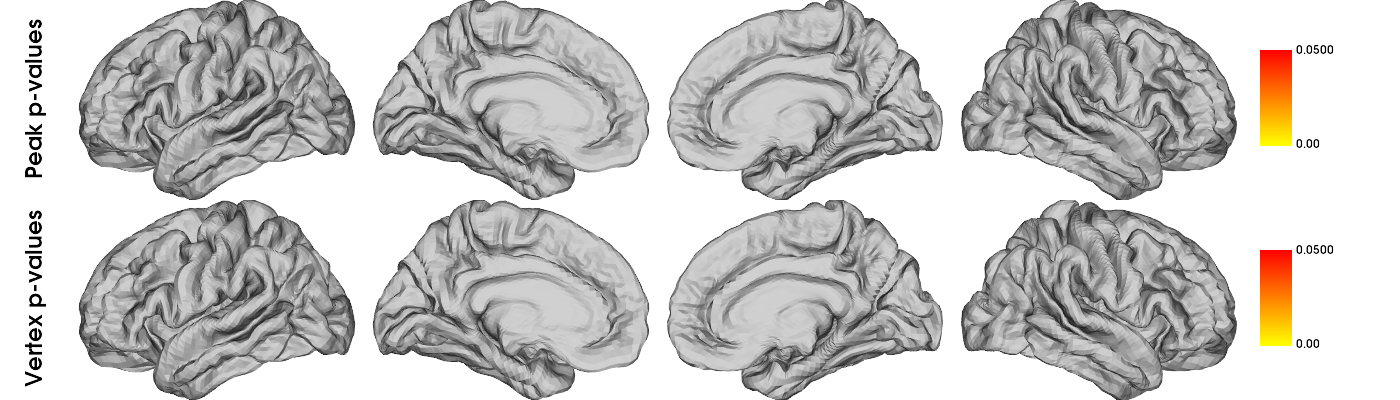

In [ ]:
# ------------------------------
# 独立样本T检验
# ------------------------------
# 这里有一个重要的Note，我们的数据并不是两组独立被试，不应该做独立样本T检验，这里只是介绍一些如何做
class Independent_SampleTTest:
    """
    独立样本T检验模块.
    """
    def __init__(self, data_importer: DataImporter, surface_name: str = "fsaverage5"):
        """
        初始化独立样本T检验器。

        Parameters:
        -----------
        data_importer : DataImporter
            数据导入器对象。
        surface_name : str, optional
            表面模板名称，默认为 "fsaverage5"
        """
        self.data_importer = data_importer
        self.surface_name = surface_name

    def run_test(self) -> SLM:
        """
        运行独立样本T检验。

        Returns:
        --------
        SLM
            BrainStat SLM对象，包含统计结果。
        """
        print("\n执行独立样本T检验: accept vs reject")

        conditions = ['strongly_accept', 'weakly_accept', 'strongly_reject', 'weakly_reject']
        data = self.data_importer.get_data_for_analysis(conditions)

        # 如果数据获取失败，直接返回None
        if data is None or data.shape[1] != 4:  # 检查是否成功获取数据, 并且有4个条件
            print(f"没有 accept 和 reject 的有效数据，或数据维度错误，跳过独立样本T检验。")
            return None

        n_subjects = data.shape[0]  # 获取被试数量

        # 计算 accept 和 reject 的平均值
        accept_data = np.mean(data[:, [0, 1], :], axis=1)  # 平均 strongly_accept 和 weakly_accept, (被试数量, 顶点数量)
        reject_data = np.mean(data[:, [2, 3], :], axis=1)  # 平均 strongly_reject 和 weakly_reject, (被试数量, 顶点数量)

        # 创建长格式数据和对应的 decision 变量
        data_long = np.concatenate([accept_data, reject_data], axis=0)  # 拼接 accept 和 reject 的数据, (2 * 被试数量, 顶点数量)
        decision = np.concatenate([np.zeros(n_subjects), np.ones(n_subjects)])  # 0: accept, 1: reject, (2 * 被试数量)
        decision_str = np.array(np.int16(decision), dtype=str)  # 转换为字符串
        
        # 创建设计矩阵 (使用pandas DataFrame，更易于处理)
        design = pd.DataFrame({
            'decision': decision_str,  # 0: accept, 1: reject
        })
        
        # 创建固定效应, 使用设计矩阵
        decision_effect = FixedEffect(design[['decision']])
        
        # 创建对比向量, (reject - accept)
        contrast = (design['decision'] == '1').astype(int) - (design['decision'] == '0').astype(int)
        
        # 创建SLM对象
        model = decision_effect
        slm = SLM(
            model=model,
            contrast=contrast,
            surf=self.surface_name,  # 使用表面模板名称
            mask=None,               # 不使用mask
            correction=['fdr', 'rft'],  # 使用FDR和RFT校正
            cluster_threshold=0.001,
            two_tailed=True
        )

        # 拟合模型
        try:
            slm.fit(data_long)
            print("独立样本T检验完成")
            return slm
        except Exception as e:
            print(f"拟合模型时出错: {e}")
            return None

# 创建 Independent T 对象
indT_test = Independent_SampleTTest(data_importer, surface_name="fsaverage5")
# 运行独立样本T检验
slm_Ind = indT_test.run_test()
#
#slm_Ind.P["pval"]['C'] is None 说明没有检测到小于p小于 0.001 时的cluster 
#
pp = [np.copy(slm_Ind.P["pval"]["P"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in pp]
# vertex 水平的fdr 校正
qp = [np.copy(slm_Ind.Q)]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in qp]
vals = np.vstack([pp[0].T, qp[0].T])
plot_hemispheres(pial_left, pial_right, vals, color_bar=True, color_range=(0, 0.05),
        label_text=["Peak p-values", "Vertex p-values"], cmap="autumn_r", 
        embed_nb=True, size=(1400, 400), zoom=1.8, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12}, interactive=False)

In [ ]:
slm_Ind.P["pval"]['C']

array([1., 1., 1., ..., 1., 1., 1.])